In [92]:
import os
import numpy as np
import src.p04_gmm as p04_gmm
import src.p05_kmeans as p05_kmeans

import matplotlib.pyplot as plt

from pythetatools.config_visualisation import t2k_style
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem 1

\begin{align*}
z^{[1]} & = W^{[1]} x + W_0^{[1]} \\
h & = \sigma (z^{[1]}) \\
z^{[2]} & = W^{[2]} h + W_0^{[2]} \\
o & = \sigma (z^{[2]}) \\
L & = \frac{1}{m} \sum_{i = 1}^{m} (o^{(i)} - y^{(i)})^2 = \frac{1}{m} (o - y)^T (o - y) \\
\end{align*}

Using chain rule and tensor denotation one can get:
\begin{align*}
\frac{\partial L}{\partial W^{[L-1]}} = (\sigma^\prime(z^{[L]}) \odot \frac{\partial L}{\partial o})_\nu \sigma^\prime (z_{i\nu}^{[L-1]})a_{j \nu}^{[L-2]} w_i^{[L]} = (W^{[L]} \odot \sigma^\prime(z^{[L-1]})) (\sigma^\prime(z^{[L]}) \odot \frac{\partial L}{\partial o} \odot a^{[L-2]})
\end{align*}

Then for $\frac{\partial L}{\partial w^{1}_{12}}$:

\begin{align*}
\frac{\partial L}{\partial w^{1}_{12}} = \frac{\partial L}{\partial W^{1}_{21}} = \frac{2}{m} w_{2}^2 (h_2 \odot (1 - h_2)) o \odot (1-o) \odot (o-y)\odot x
\end{align*}

In case of step activation function (not linear) it is possible to achieve 100% accuracy (optimal weights are provided in src.p01_nn.py). Basically, you construct the triangle (3 neurons for 3 sides). 

Using linear activation function the $o$ will be linear combination of the inputs $x$. So, the decision boundary will be a straight line for any weights. Thus, 100% accuracy is not possible. 

## Problem 4: EM for Gaussian Mixture Models (unsupervised and semi-supervised)

Running semi-supervised EM algorithm...
Trial 0
0 -2394.856103437583
10 -1791.937622373967
20 -1791.8927654225138
30 -1791.6112389748198
Trial 1
0 -2393.5996285285537
10 -1793.9605998331717
20 -1791.625619443927
Trial 2
0 -2389.815636894164
10 -1793.1773115424558
20 -1792.0823510147961
30 -1791.621797734469


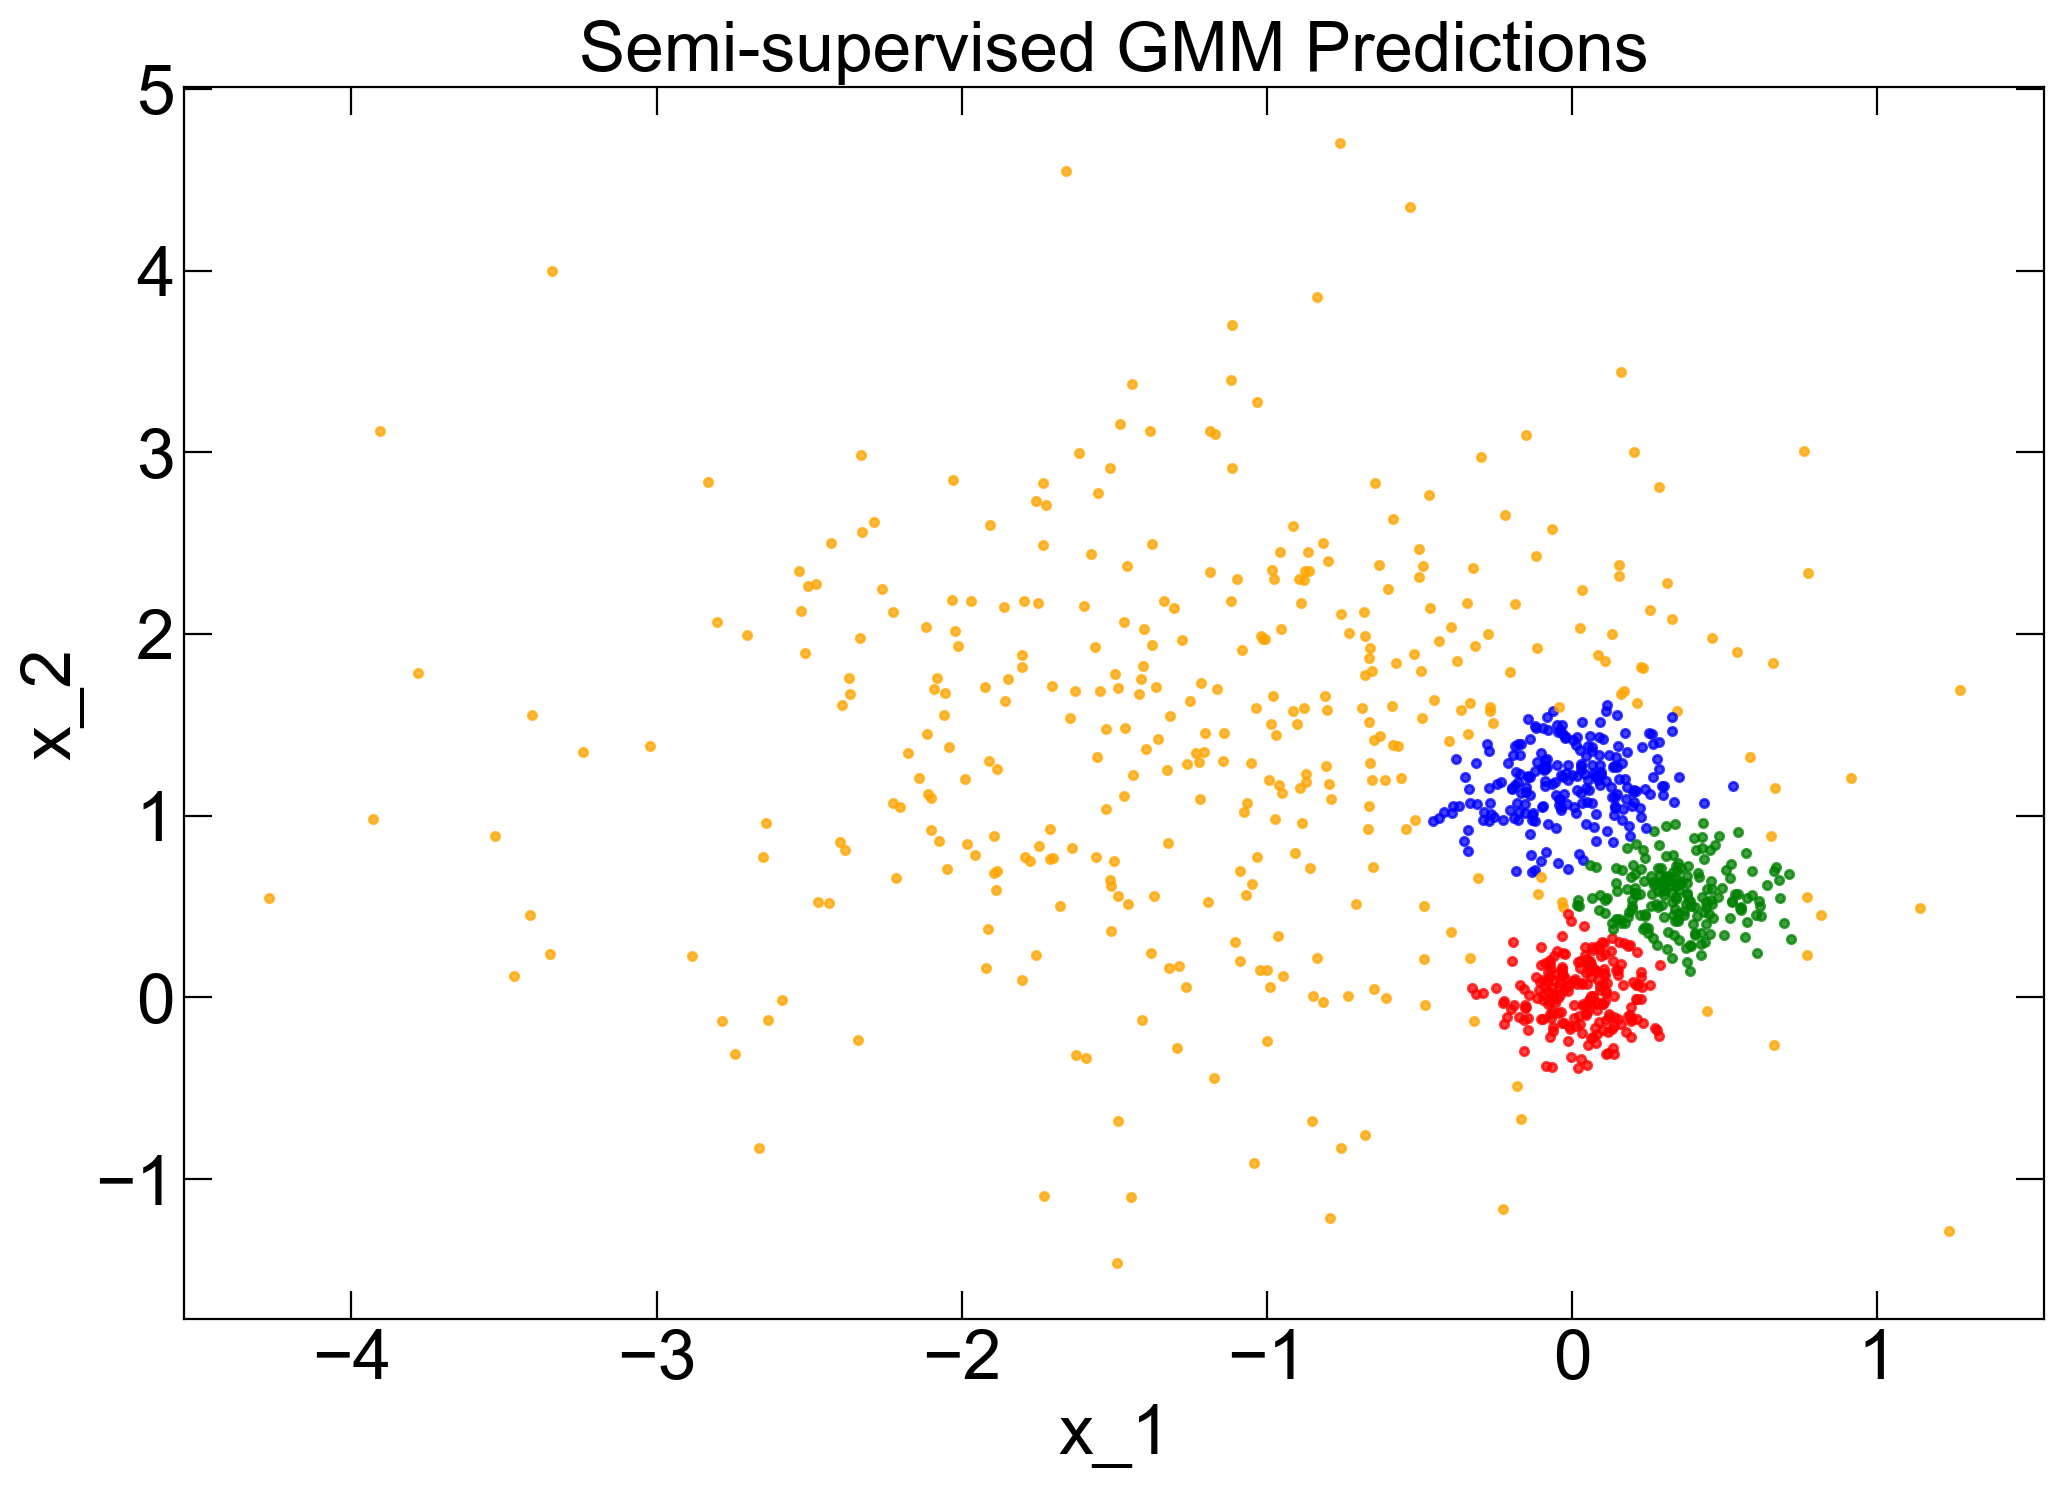

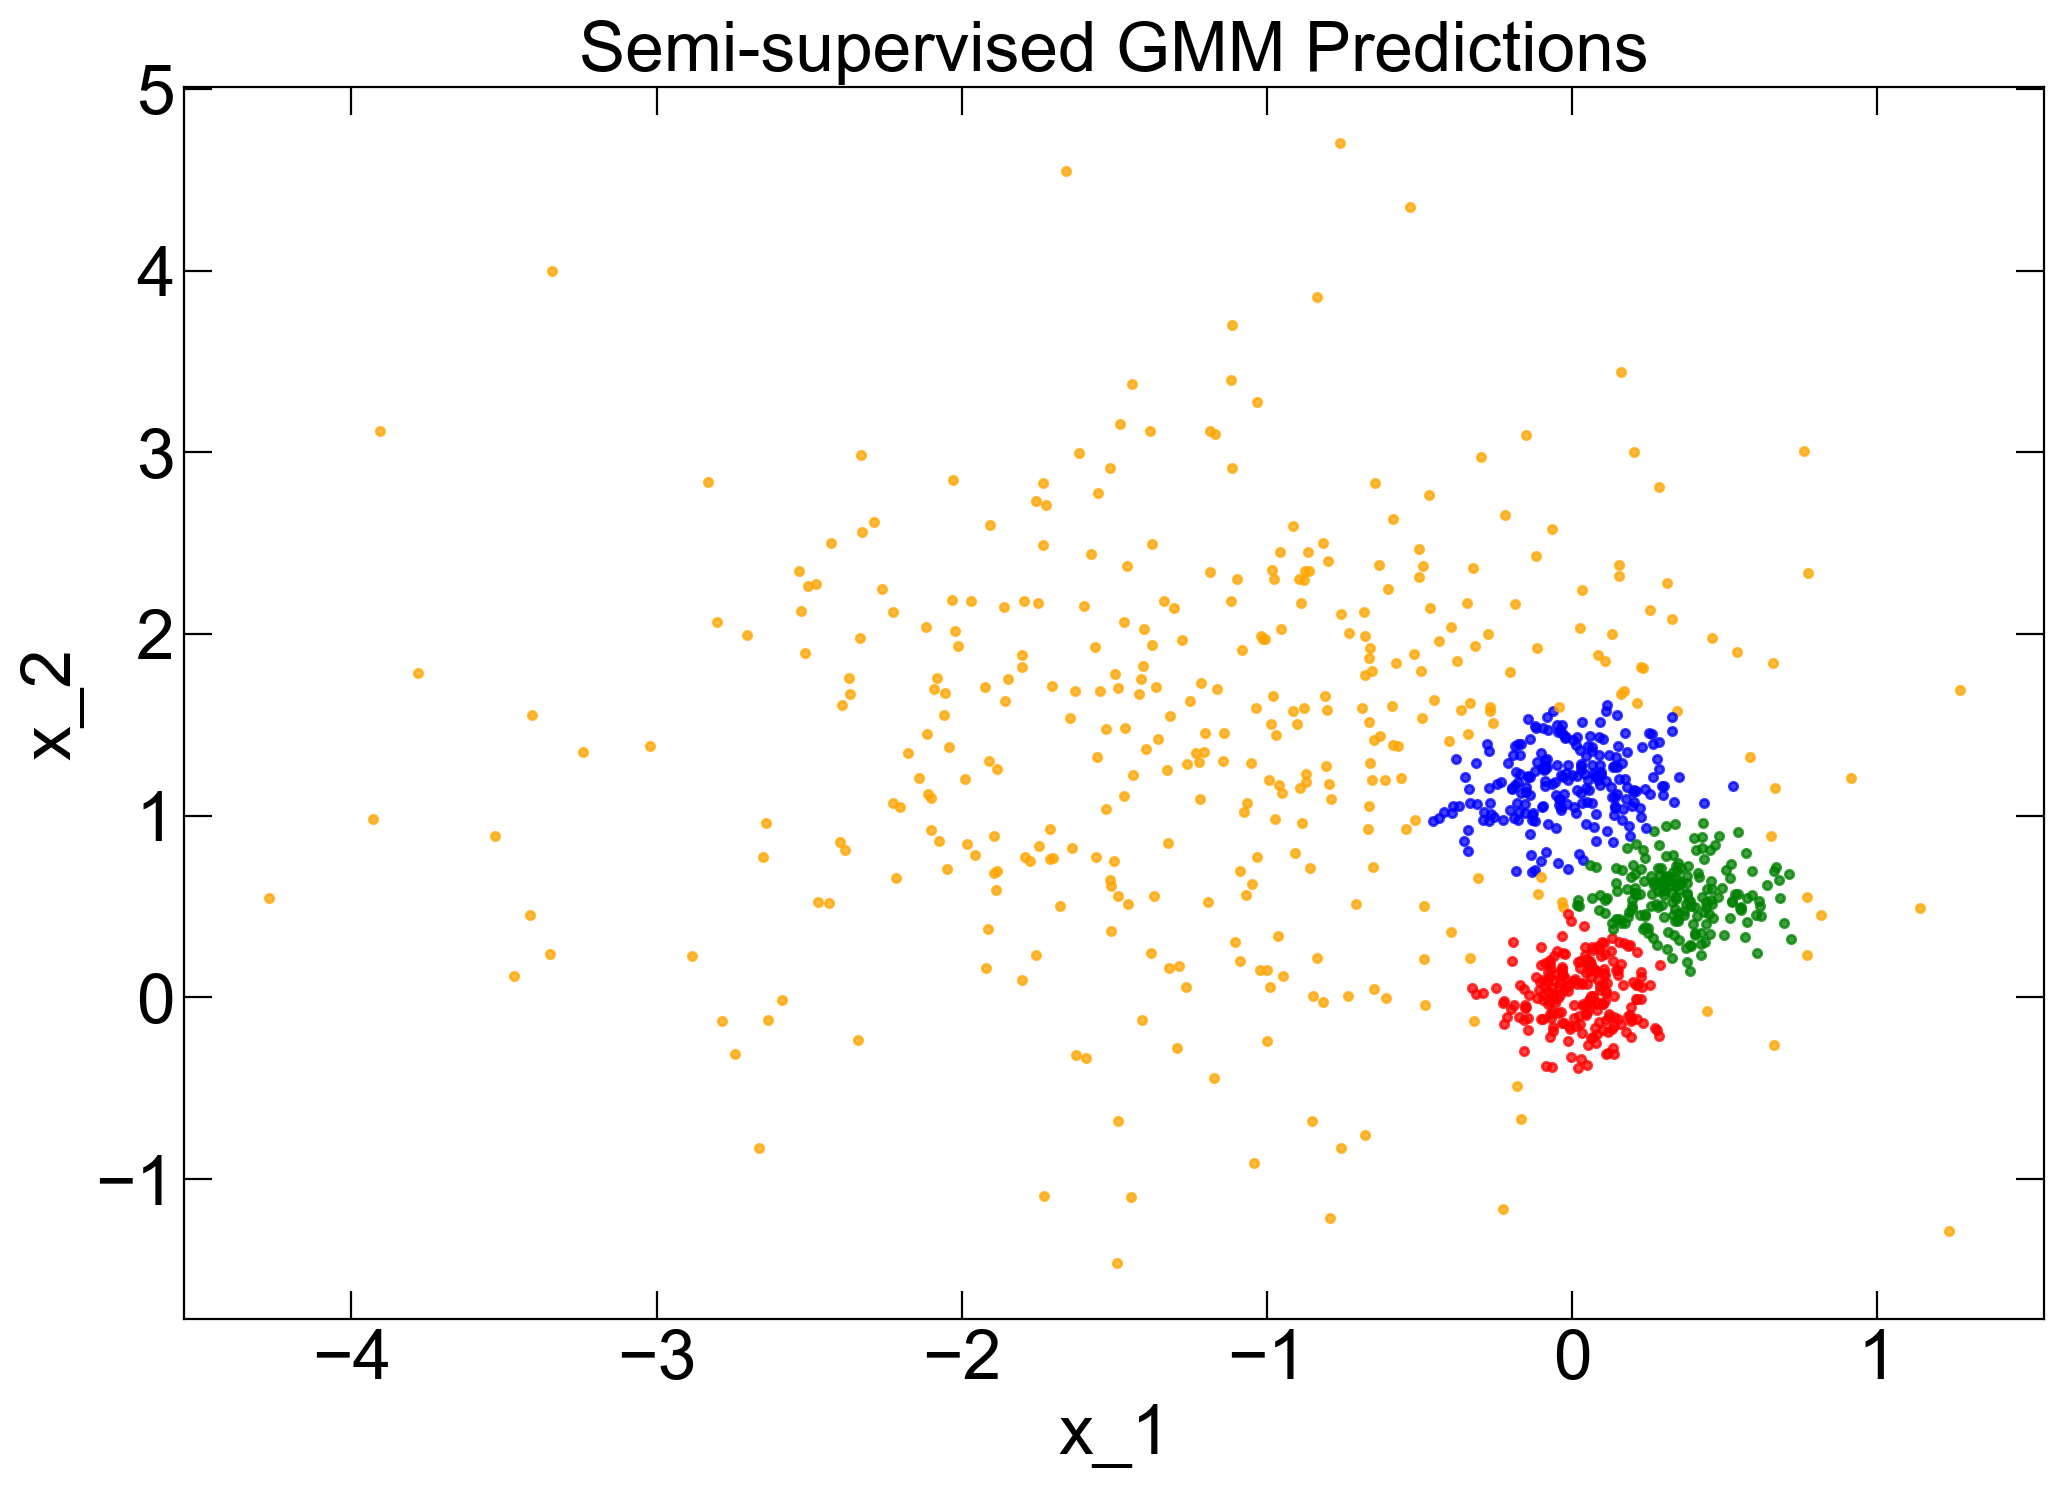

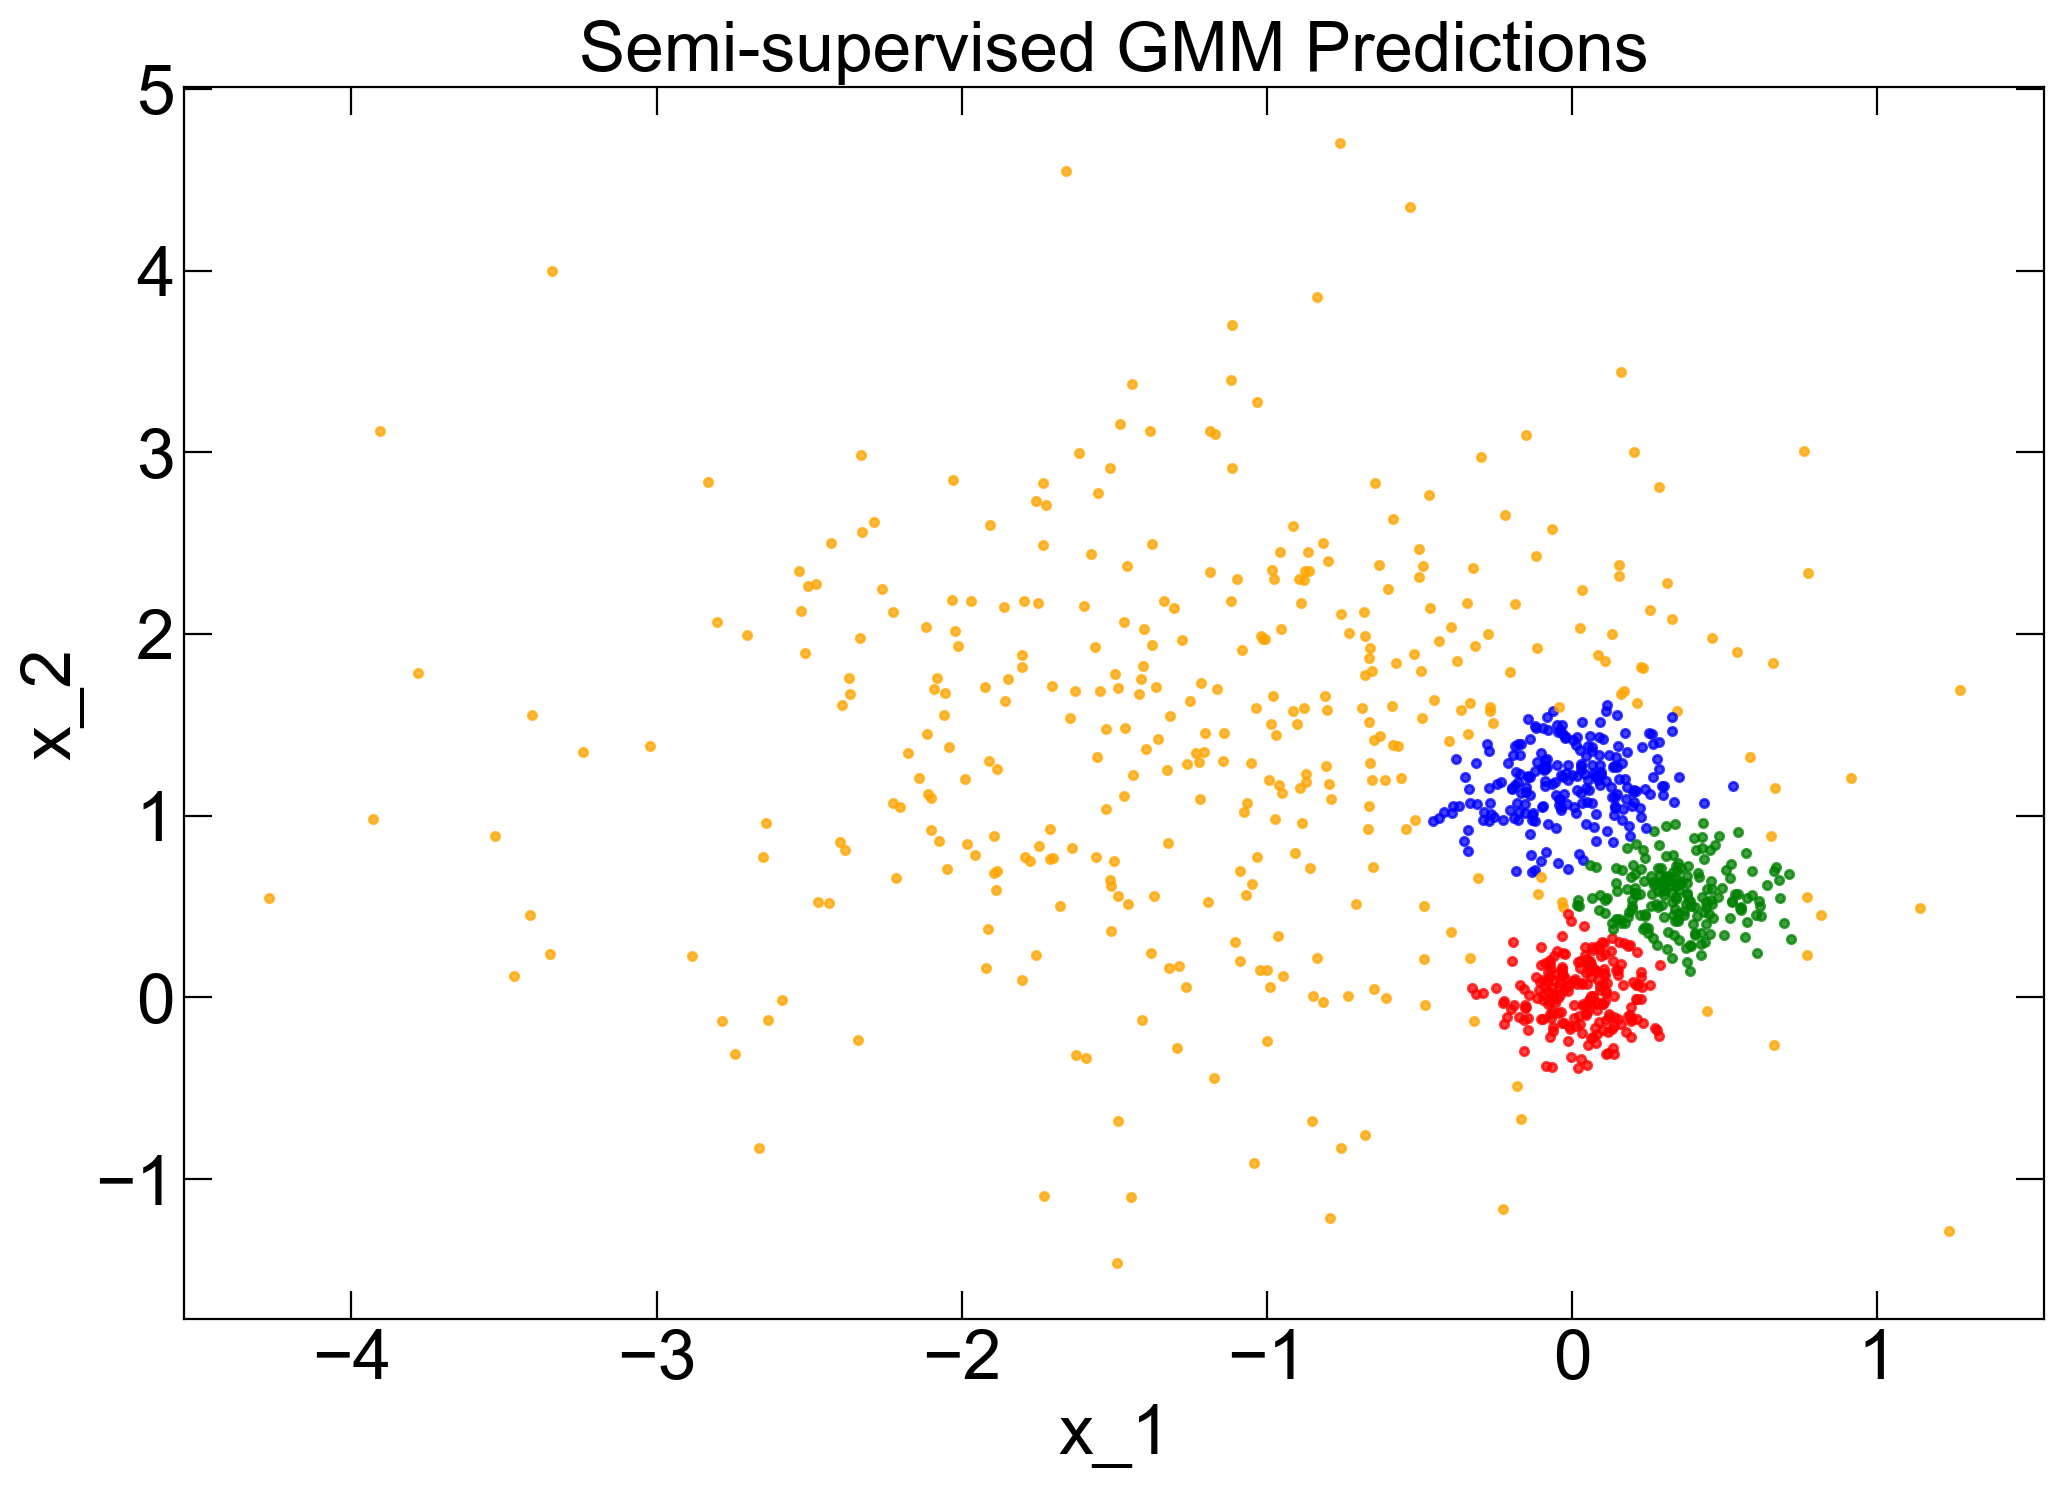

In [81]:
is_semi_supervised = True
smart_init = False

print('Running {} EM algorithm...'.format('semi-supervised' if is_semi_supervised else 'unsupervised'))

# Load dataset
train_path = os.path.join('data', 'ds3_train.csv')
x, z = p04_gmm.load_gmm_dataset(train_path)
x_tilde = None

if is_semi_supervised:
    # Split into labeled and unlabeled examples
    labeled_idxs = (z != p04_gmm.UNLABELED).squeeze()
    x_tilde = x[labeled_idxs, :]   # Labeled examples
    z = z[labeled_idxs, :]         # Corresponding labels
    x = x[~labeled_idxs, :]        # Unlabeled examples

for trial_num  in range(p04_gmm.NUM_TRIALS):
    # *** START CODE HERE ***
    print(f'Trial {trial_num}')
    m, n = x.shape
    mu = []
    sigma = []
    
    if is_semi_supervised and smart_init:
        for j in range(p04_gmm.K):
            mu.append(np.mean(x_tilde[(z==j)[:,0]], axis=0))
            sigma.append(np.cov(x_tilde[(z==j)[:,0]].T))
    else:
        shuffled_pos = np.random.permutation(x)
        parts = np.array_split(shuffled_pos, p04_gmm.K)
        for j in range(p04_gmm.K):
            mu.append(np.mean(parts[j], axis=0))
            sigma.append(np.cov(parts[j].T))
    
    phi = np.ones(p04_gmm.K)/p04_gmm.K
    w = np.ones((m, p04_gmm.K))*phi
    # *** END CODE HERE ***
    
    if is_semi_supervised:
        w = p04_gmm.run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma)
    else:
        w = p04_gmm.run_em(x, w, phi, mu, sigma)
    
    # Plot your predictions
    z_pred = np.zeros(m)
    if w is not None:  # Just a placeholder for the starter code
        for i in range(m):
            z_pred[i] = np.argmax(w[i])
    
    p04_gmm.plot_gmm_preds(x, z_pred, is_semi_supervised, plot_id=trial_num)

Conclusion: Semi-supervised converges faster; more stable wrt to initialisation and much closer to true distributions

## Problem 4

In [87]:
from matplotlib.image import imread

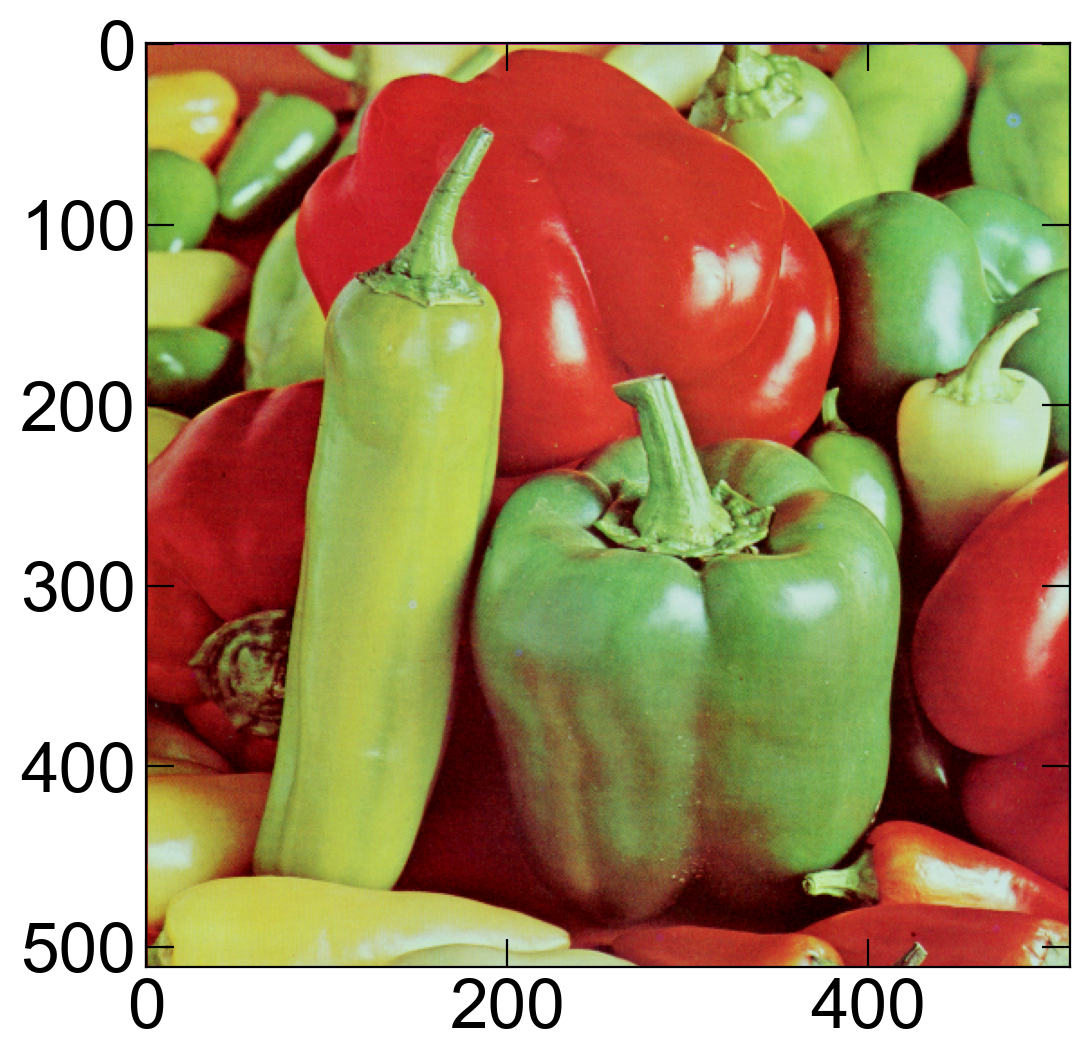

In [147]:
A = imread('data/peppers-large.tiff')
plt.imshow(A)

In [152]:
npix = A.shape[0]

K = 8 #number of clusters
x = A.reshape(-1, 3) #each pixel is treated as a datapoint xi

#mu initialisation
sel = np.random.randint(0, x.shape[0]-1, K)
mu0 = x[sel, :]


In [153]:
c, mu = p05_kmeans.run_kmeans(x, mu0, K)
compressed_image_flat = mu[c].astype(int)   # shape = (npix*npix, n_channels)
compressed_image = compressed_image_flat.reshape(npix, npix, -1)
compressed_image.shape

(512, 512, 3)

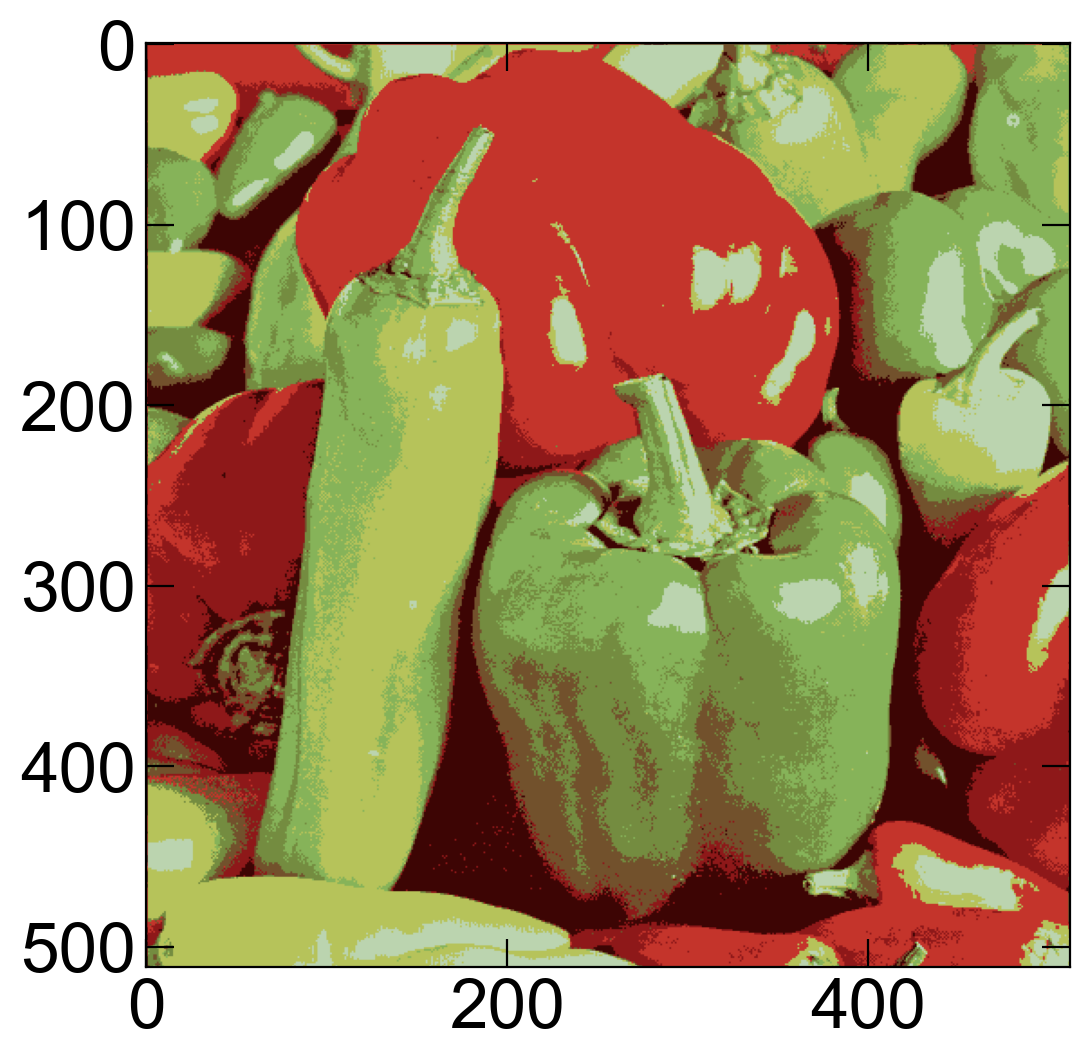

In [154]:
plt.imshow(compressed_image)